# Aligatou Project 
## Riyadh Artathon 2020,1,25
Maha , Ali, Afaaf

In [44]:
from pathlib import Path
from collections import defaultdict

from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder, CIFAR10

In [45]:
dataset_path = "./four-shapes/shapes/" #Kagel Dataset 

# Generative Adversarial Network

In [46]:
class Discriminator(nn.Module):
    def __init__(self, channels=1, memory=64):
        super().__init__()
        self.features = nn.Sequential(  # fully convolutional model
        nn.Conv2d(channels, memory, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(memory, memory * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(memory * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(memory * 2, memory * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(memory * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(memory * 4, memory * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(memory * 8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(memory * 8, 1, 4, 1, 0, bias=False),
        )
    # self.classifier = nn.Sequential(
    #   nn.AdaptiveAvgPool2d((1, 1)),
    #   nn.Flatten(1),
    #   nn.Sigmoid(),
    # )

    def forward(self, images):
    # return self.classifier(self.features(images))
    # or equivalently
        return self.features(images).flatten(1).mean(1, keepdim=True).sigmoid()


# the most common loss function for classification is F.cross_entropy

In [47]:
class Generator(nn.Module):
    def __init__(self, input_dim=100, channels=1, memory=64):
        super().__init__()
        self.input_dim = input_dim
        self.decoder = nn.Sequential(  # fully convolutional model
        nn.ConvTranspose2d(input_dim, memory * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(memory * 8),
        nn.ReLU(True),
        nn.ConvTranspose2d(memory * 8, memory * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(memory * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(memory * 4, memory * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(memory * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(memory * 2, memory, 4, 2, 1, bias=False),
        nn.BatchNorm2d(memory),
        nn.ReLU(True),
        nn.ConvTranspose2d(memory, channels, 4, 2, 1, bias=False),
        nn.Tanh()
        )

    def forward(self, latent_code):
        return self.decoder(latent_code.view(-1, self.input_dim, 1, 1))

In [48]:
# define commonly-changed training options
dataset = './four-shapes/shapes/'  # you can put a path to image folder
channels = 1         # RGB vs gray-scale
batch_size = 104      # input batch size

z_dim = 100          # size of the latent z vector
image_size = 64      # the height / width of the input image
capacity_d = 64      # size factor (memory) for the discriminator
capacity_g = 64      # size factor (memory) for the generator

epochs = 5          # number of epochs
lr = 0.0002          # learning rate for the optimizer (Adam)
beta1 = 0.5          # Adam beta1: exponential decay rate for the 1st moment

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [49]:
# get the dataset and initialize the data loader
def get_dataset(dataset, image_size=image_size, channels=channels):
    Dataset = ImageFolder
    directory = Path(dataset)
    return Dataset(directory, transform=transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize([0.5] * channels, [0.5] * channels),
    ]))

data_loader = DataLoader(get_dataset(dataset), batch_size,
                         shuffle=True, drop_last=True, num_workers=4)

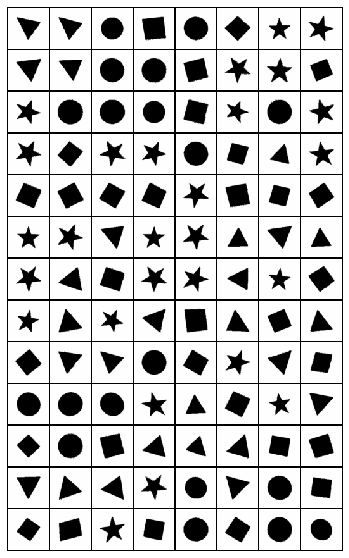

In [50]:
def plot_image_grid(images, columns=8, ax=None, show=True):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 10))
    image_grid = make_grid(images.detach().cpu(), columns, normalize=True)
    ax.imshow(image_grid.permute(1, 2, 0), interpolation='nearest')
    ax.axis('off')
    if show:
        plt.show(ax.figure)
    return ax

_ = plot_image_grid(next(iter(data_loader))[0])

In [51]:
# create the discriminator (net_d) and the generator (net_g)
net_d = Discriminator(channels, memory=capacity_d).to(device)
net_g = Generator(z_dim, channels, memory=capacity_g).to(device)

# setup an optimizer for each model
optimizer_d = Adam(net_d.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_g = Adam(net_g.parameters(), lr=lr, betas=(beta1, 0.999))

# create fixed noise, to track generator progress, and labels
fixed_noise = torch.randn(batch_size, z_dim, device=device)
real_label = torch.ones(batch_size, 1, device=device)
fake_label = torch.zeros(batch_size, 1, device=device)

# define how you would like the progress to be printed
states = []   # save the state of our GAN after each epoch
metrics = []  # metrics to monitor
def progress(log):
    total = len(log['loss/gen'])
    err_g = sum(log['loss/gen']) / total
    err_d_real = sum(log['loss/d_real']) / total
    err_d_fake = sum(log['loss/d_fake']) / total
    d_x = sum(log['score/d_real']) / total
    d_g_z1 = sum(log['score/d_fake']) / total
    d_g_z2 = sum(log['score/gen']) / total
    return (f'\rLoss_D: {err_d_real + err_d_fake:.4f} Loss_G: {err_g:.4f} '
          f'D(x): {d_x:.4f} D(G(z)): {d_g_z1:.4f} / {d_g_z2:.4f}')

In [52]:
def analyze(images, labels, binary_classifier):
    scores = binary_classifier(images)  # values in [0, 1]
    loss = F.binary_cross_entropy(scores, labels)
    if loss.requires_grad:
        loss.backward()  # compute gradients
    return float(loss), float(scores.detach().mean())

Epoch [0/4]
Loss_D: 0.7741 Loss_G: 4.2363 D(x): 0.7913 D(G(z)): 0.2240 / 0.1301


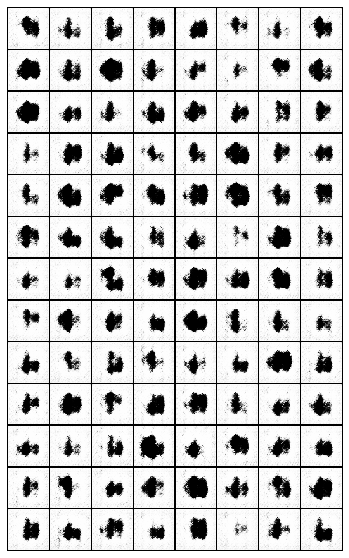

Epoch [1/4]
Loss_D: 0.9850 Loss_G: 1.6891 D(x): 0.6628 D(G(z)): 0.3447 / 0.2547


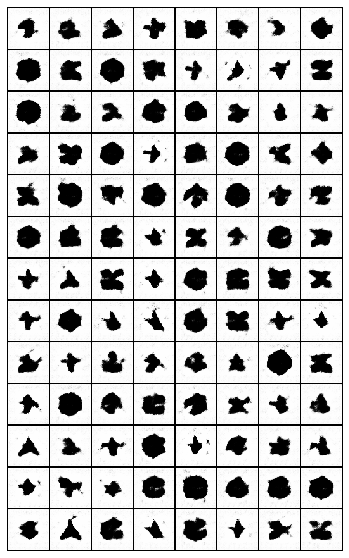

Epoch [2/4]
Loss_D: 0.8820 Loss_G: 1.9603 D(x): 0.6934 D(G(z)): 0.2967 / 0.2219

In [ ]:
# start training
for epoch in range(len(metrics), epochs):
    print(f'Epoch [{epoch}/{epochs - 1}]')
    net_g.train(True)
    log = defaultdict(list)
    metrics.append(log)
    for i, data in enumerate(data_loader):
    # sample real (from dataset) and fake (using net_g) images
        real = data[0].to(device)  # real images
        fake = net_g(torch.randn(real.size(0), z_dim, device=device))
        fake_detached = fake.detach()

    # train the dicriminator: maximize log(D(x)) + log(1 - D(G(z)))
        optimizer_d.zero_grad()
        err_d_real, d_x = analyze(real, real_label, net_d)
        err_d_fake, d_g_z1 = analyze(fake_detached, fake_label, net_d)
        optimizer_d.step()  # learn
    
    # train the generator: maximize log(D(G(z)))
        optimizer_g.zero_grad()
        err_g, d_g_z2 = analyze(fake, real_label, net_d)
        optimizer_g.step()  # learn

    ##############################################################

    # record the metrics
        log['loss/d_real'].append(err_d_real)
        log['loss/d_fake'].append(err_d_fake)
        log['loss/gen'].append(err_g)
        log['score/d_real'].append(d_x)        # D(x)
        log['score/d_fake'].append(d_g_z1)     # D(G(z_1))
        log['score/gen'].append(d_g_z2)        # D(G(z_2))

        if i % 10 == 0:
            print(progress(log), end='')

  # display progress with few examples after every epoch
    print(progress(log))
    with torch.no_grad():
        net_g.train(False)
        epoch_samples = net_g(fixed_noise)
    ax = plot_image_grid(epoch_samples)
  # ax.figure.savefig(f'./samples_{epoch:03d}.png')

  # save your progress in a checkpoint (optional)
    state = {
      'log': log,
      'epoch': epoch,
      'net_d': net_d.state_dict(),
      'net_g': net_g.state_dict(),
      'opt_d': optimizer_d.state_dict(),
      'opt_g': optimizer_g.state_dict(),
  }
  # torch.save(state, f'./gan_{epoch:03d}.pth')
    states.append(state)
    if len(states) > 3:  # keep only the last 3 states
        states.pop(0)

In [ ]:
# every time you run this, you will plot new randomly generated samples
with torch.no_grad():
    net_g.train(False)
    z = torch.randn(batch_size, z_dim, device=device)
    plot_image_grid(net_g(z * 0.007))

# Getting the outlines of the output shape

In [3]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
import cv2 as cv
im = cv.imread('./2.png')
#mask=im.convert("L")
imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(imgray, 127, 255, 0)
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

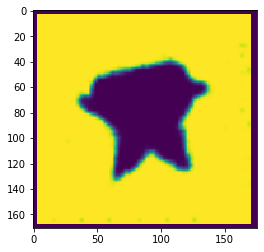

In [21]:
cnt = contours[0]
plt.imshow(cv.drawContours(imgray, [cnt], 0, (0,255,0), 3))

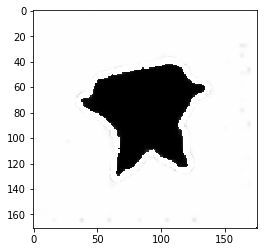

In [24]:
import matplotlib.pyplot as plt
plt.imshow(im)

In [23]:
cv.imshow('Contour on Image', cv.drawContours(imgray, [cnt], 0, (0,255,0), 3))
cv.drawContours(cv.drawContours(im, [cnt], 0, (0,255,0), 3), contours, -1, (255, 255, 255), 4)
cv.waitKey(0)
cv.destroyAllWindows()
cv.waitKey(1)

-1